<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>NLP with Deep Learning for Everyone</h1>
<h1>Word Embeddings</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import gzip
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

np.random.seed(42)

import matplotlib
import matplotlib.pyplot as plt 

from tqdm import tqdm

import sklearn
from sklearn.manifold import TSNE

import watermark

import keras
import tensorflow as tf
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: f6297d4276dfda02a7be65622fdf6e0d7a85cb58

sklearn   : 0.0
json      : 2.0.9
matplotlib: 3.3.2
watermark : 2.1.0
tensorflow: 2.5.0
keras     : 2.4.3
pandas    : 1.1.3
numpy     : 1.19.2



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Word Embeddings

We start by loading pre-computed Word Embeddings

In [4]:
word_dict = {}
word_list = []
embeddings = np.zeros((400_000, 50), dtype='float32')

count = 0

with gzip.open('data/glove.6B.50d.txt.gz', 'rt') as fp:
    for line in tqdm(fp, total=400_000):
        fields = line.split()
        word = fields[0]
        
        word_list.append(word)
        word_dict[word] = count
        
        embeddings[count] = np.asarray(fields[1:], dtype='float32') 
        count += 1

100%|██████████| 400000/400000 [00:07<00:00, 56993.79it/s]


Text(0, 0.5, 'Dimensions')

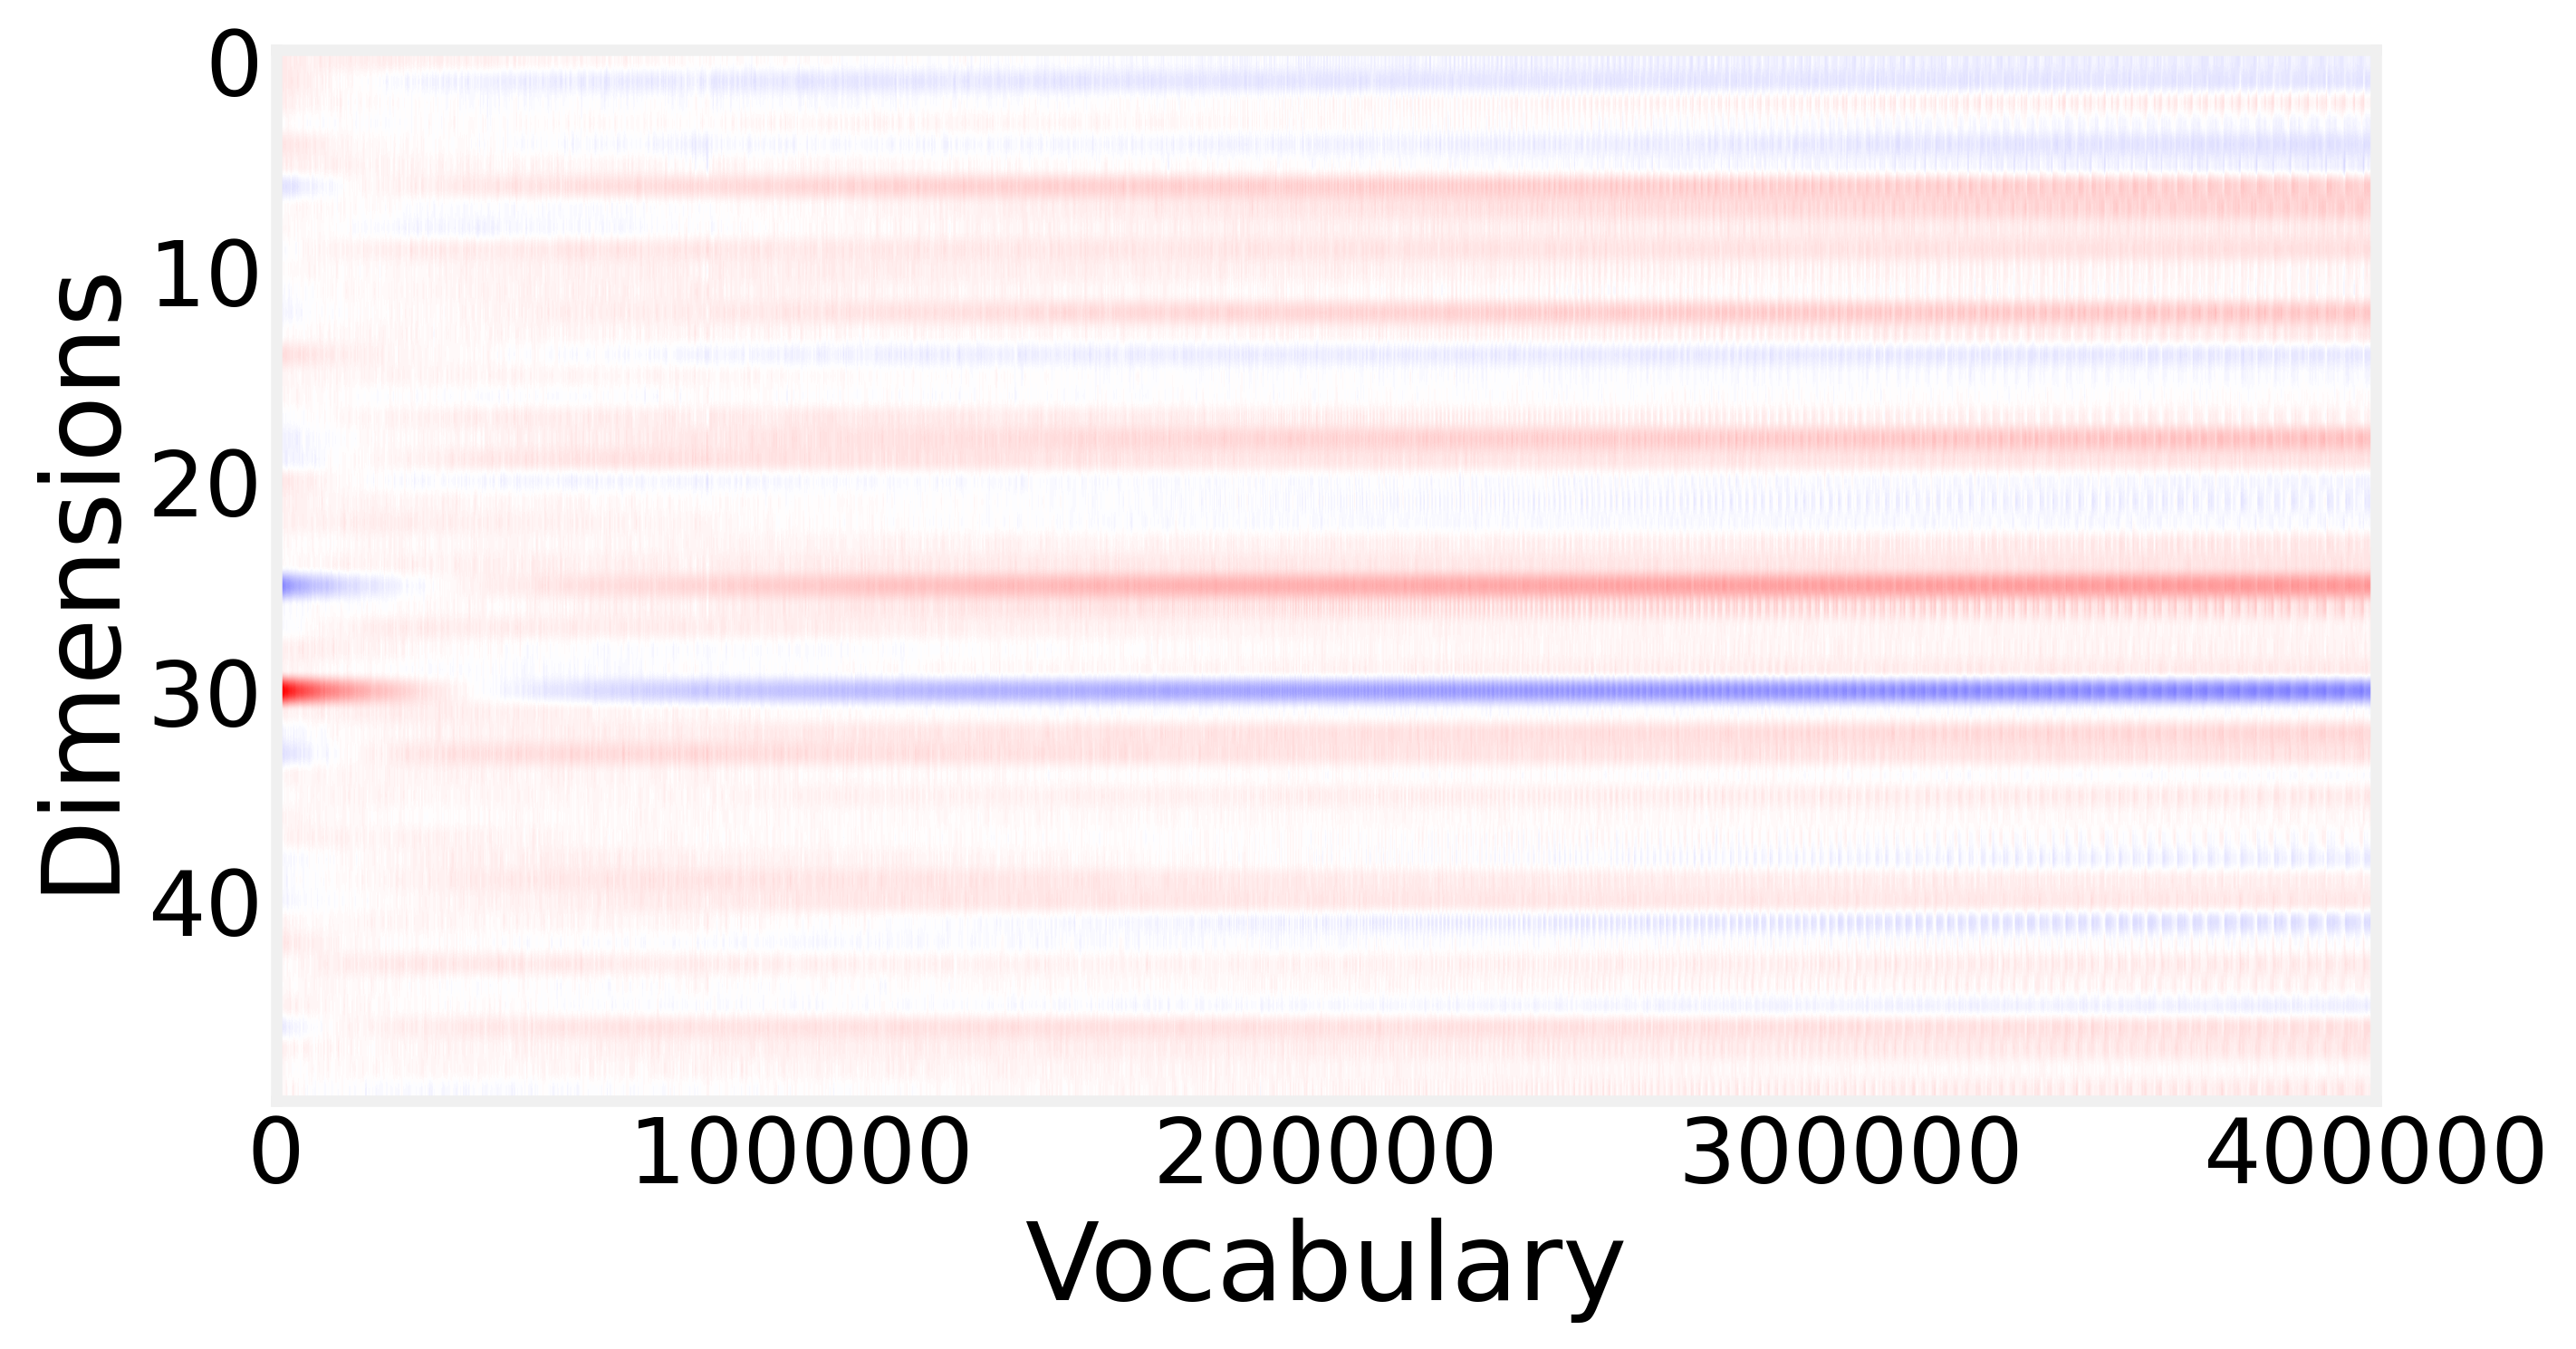

In [5]:
fig, ax = plt.subplots(1, figsize=(10, 10))

ax.imshow(embeddings.T, aspect=4000, cmap=plt.cm.seismic)
ax.grid(None)
ax.set_xticks([0, 100_000, 200_000, 300_000, 400_000])
ax.set_xlabel("Vocabulary")
ax.set_ylabel("Dimensions")

A 2D projection makes it clear that semantics is also encoded in the representation

In [6]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 500 # Plot only 500 words
low_dim_embs = tsne.fit_transform(np.array(embeddings)[:plot_only, :])

In [7]:
labels = [word_list[i] for i in range(plot_only)]

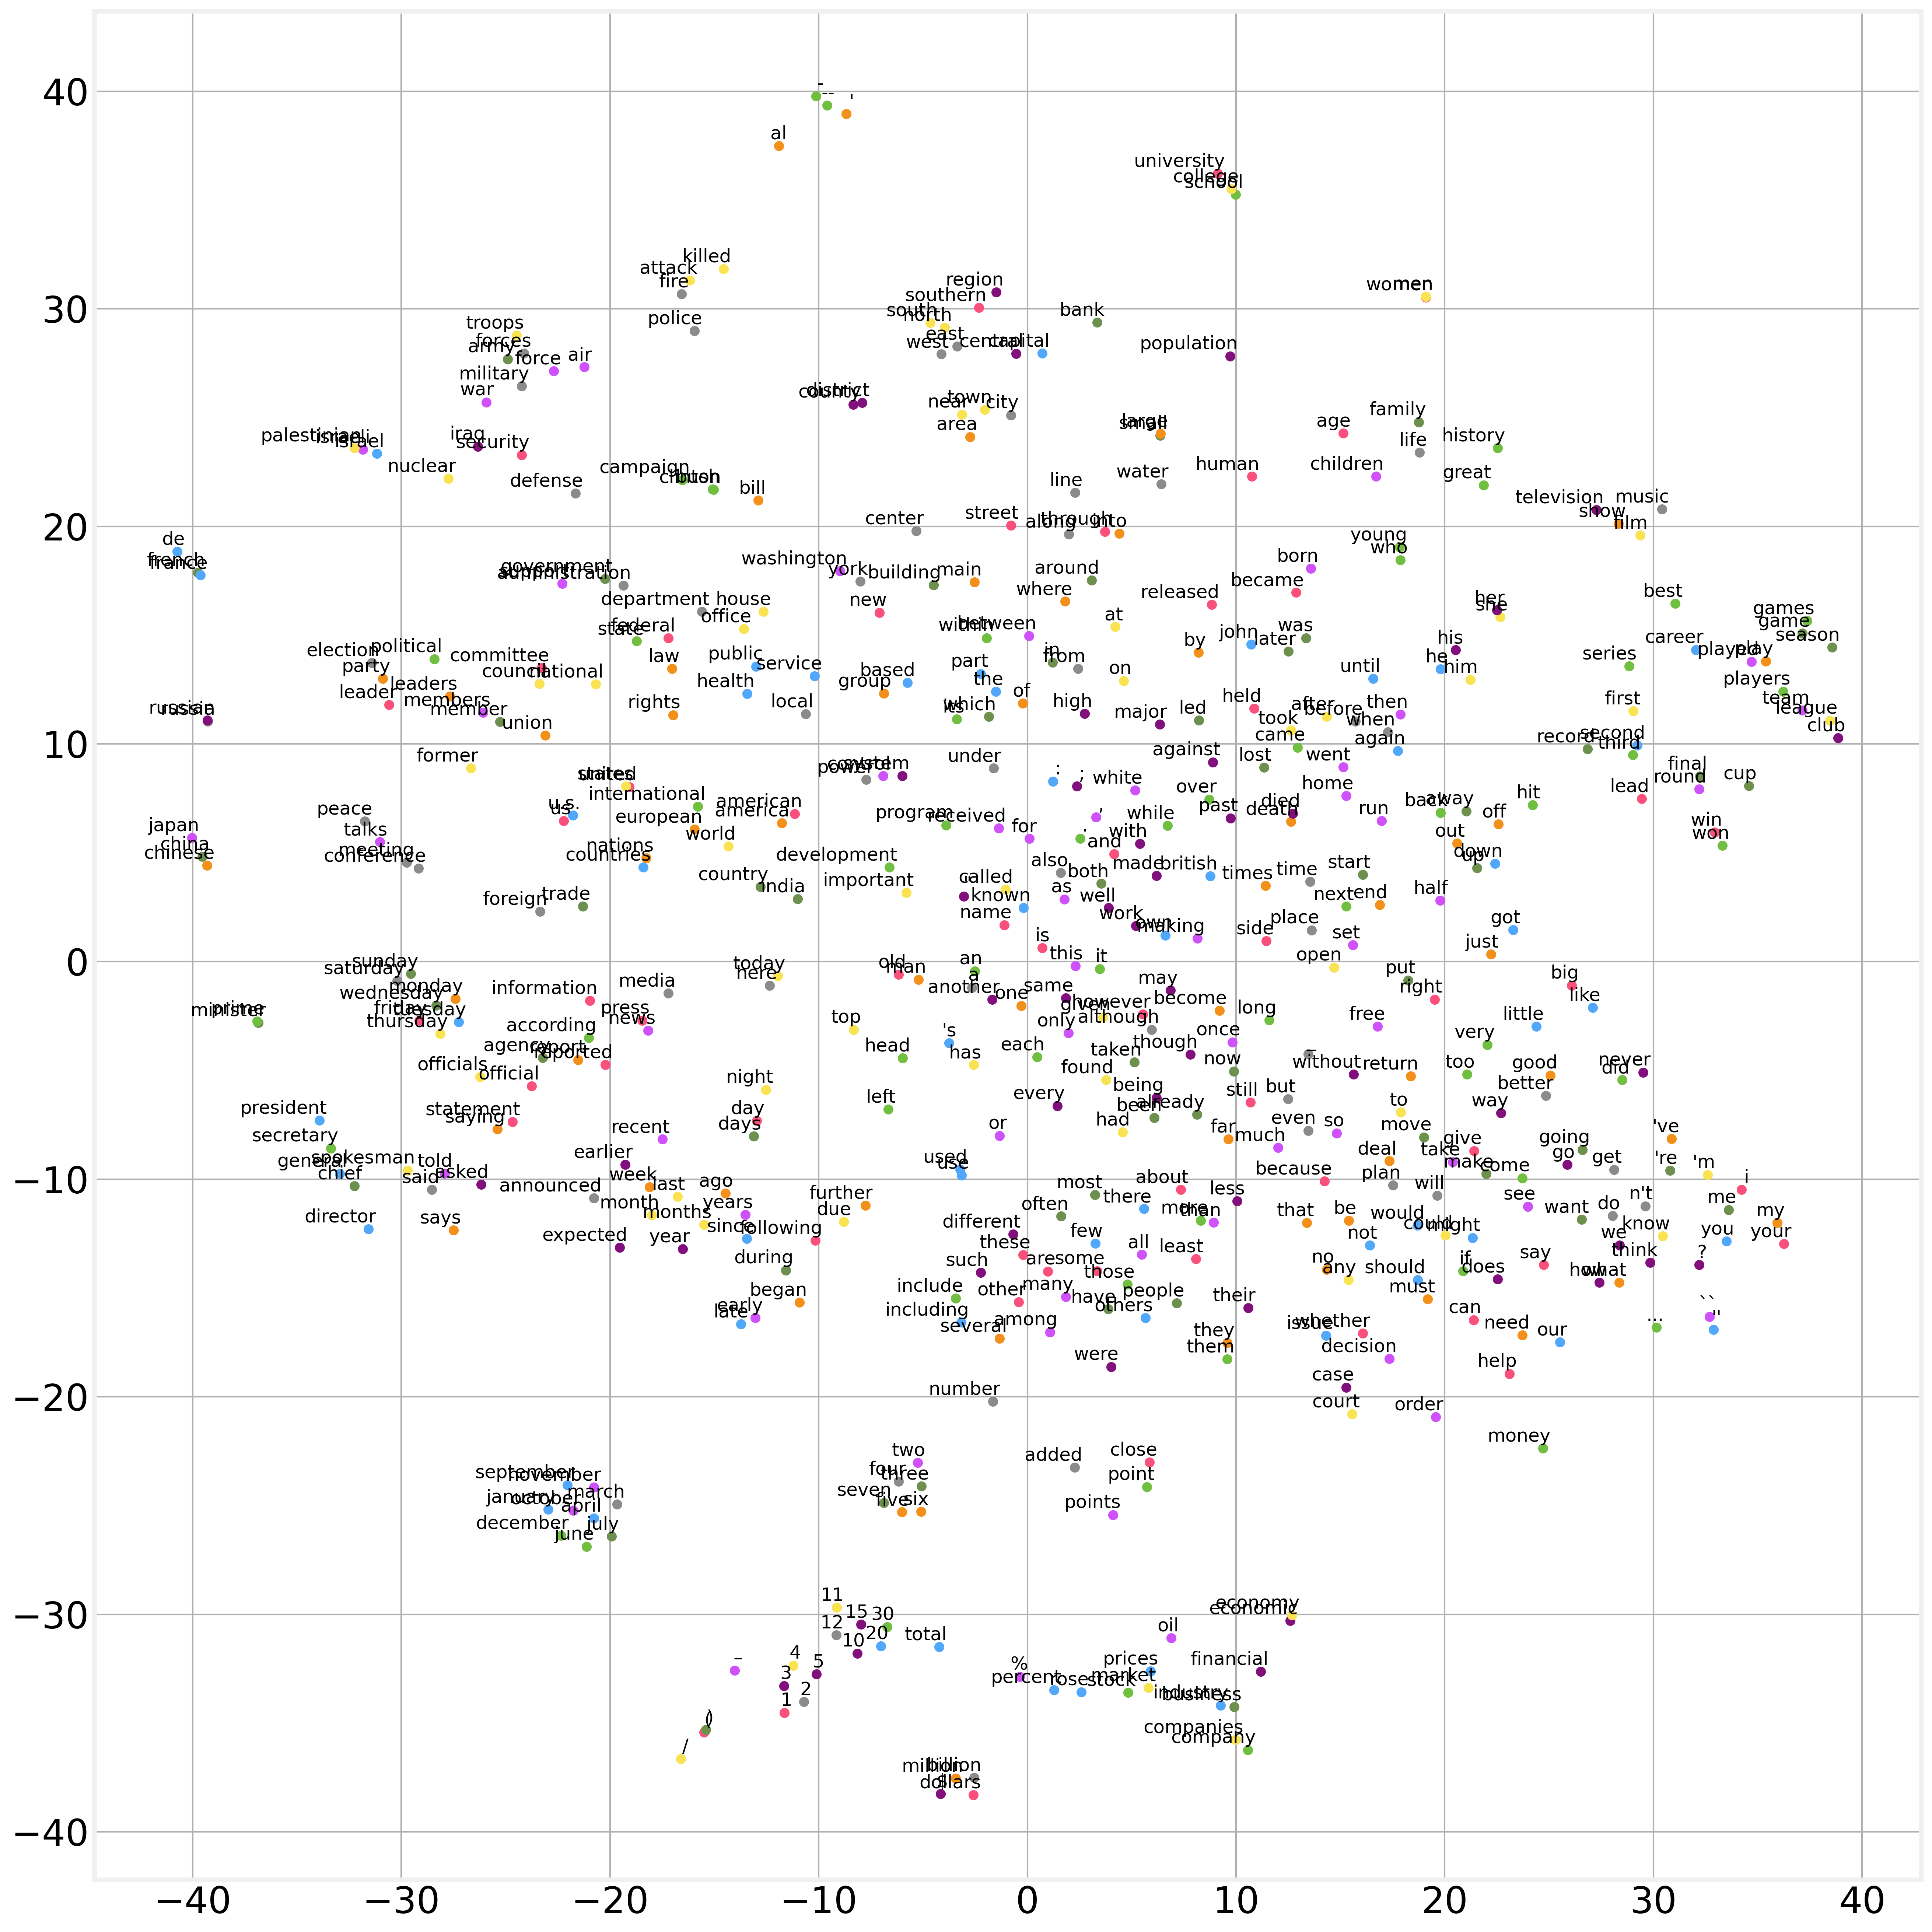

In [8]:
plt.figure(figsize=(18, 18))

for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                fontsize=12)

# Knowledge Transfer 

In [9]:
top_words = 10_000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
word_dict = imdb.get_word_index()

max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

Recall our original FF network model

In [10]:
model = Sequential()
model.add(Embedding(top_words, 50, input_length=max_words))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 50)           500000    
_________________________________________________________________
flatten (Flatten)            (None, 25000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                800032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,300,065
Trainable params: 1,300,065
Non-trainable params: 0
_________________________________________________________________


We're going to build an embedding matrix from the values we have in disk

In [11]:
embedding_matrix = np.zeros((top_words, 50), dtype='float32')
word_dict = imdb.get_word_index()

count = 0

with gzip.open('data/glove.6B.50d.txt.gz', 'rt') as fp:
    for line in tqdm(fp, total=400000):
        fields = line.split()
        word = fields[0]
        
        if word in word_dict:
            pos = word_dict[word]
            
            if pos < top_words:
                count += 1
                pos = word_dict[word]
                embedding_matrix[pos] = np.asarray(fields[1:], dtype='float32')        

100%|██████████| 400000/400000 [00:02<00:00, 142553.50it/s]


And assign this matrix to the embedding layer

In [12]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False # Don't update the embeddings

In [13]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 50)           500000    
_________________________________________________________________
flatten (Flatten)            (None, 25000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                800032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,300,065
Trainable params: 800,065
Non-trainable params: 500,000
_________________________________________________________________


Now you can see that there are 500,000 parameters that we will not need to train corresponding to 10,000 words x 50 dimensions

In [15]:
history = model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), # The testing data for validation
          epochs=10, # How many epochs to train for
          batch_size=128, # The batch size. Gradients are updated after each batch 
          verbose=1) # The level of detail in the output

Epoch 1/10
196/196 [==============================] - 11s 12ms/step - loss: 0.7526 - accuracy: 0.5013 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
196/196 [==============================] - 2s 10ms/step - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/10
196/196 [==============================] - 2s 11ms/step - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/10
196/196 [==============================] - 2s 11ms/step - loss: 0.6931 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/10
196/196 [==============================] - 2s 11ms/step - loss: 0.6932 - accuracy: 0.4997 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/10
196/196 [==============================] - 2s 11ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/10
196/196 [==============================] - 2s 11ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 0.6931 - val_accuracy: 0.500

In [16]:
def plot_history(history):    
    fig, ax_lst = plt.subplots(1, 2, sharex=True, sharey=True)

    epochs = np.array(history.epoch) + 1
    
    ax_lst[0].plot(epochs, history.history['loss'], label='Training')
    ax_lst[0].plot(epochs, history.history['val_loss'], label='Testing')
    ax_lst[0].set_ylabel('Loss')
    ax_lst[0].set_xlabel('Epoch')
    ax_lst[0].set_xticks(history.epoch)
    
    best_epoch = np.argmin(history.history['val_loss']) + 1
    ax_lst[0].axvline(x=best_epoch, linestyle=':', color=colors[2])
    ax_lst[0].legend()
    

    ax_lst[1].plot(epochs, history.history['accuracy'], label='Training')
    ax_lst[1].plot(epochs, history.history['val_accuracy'], label='Testing')
    ax_lst[1].set_ylabel('Accuracy')
    ax_lst[1].set_xlabel('Epoch')
    ax_lst[1].set_xticks(history.epoch)
    ax_lst[1].axvline(x=best_epoch, linestyle=':', color=colors[2])


    fig.tight_layout()

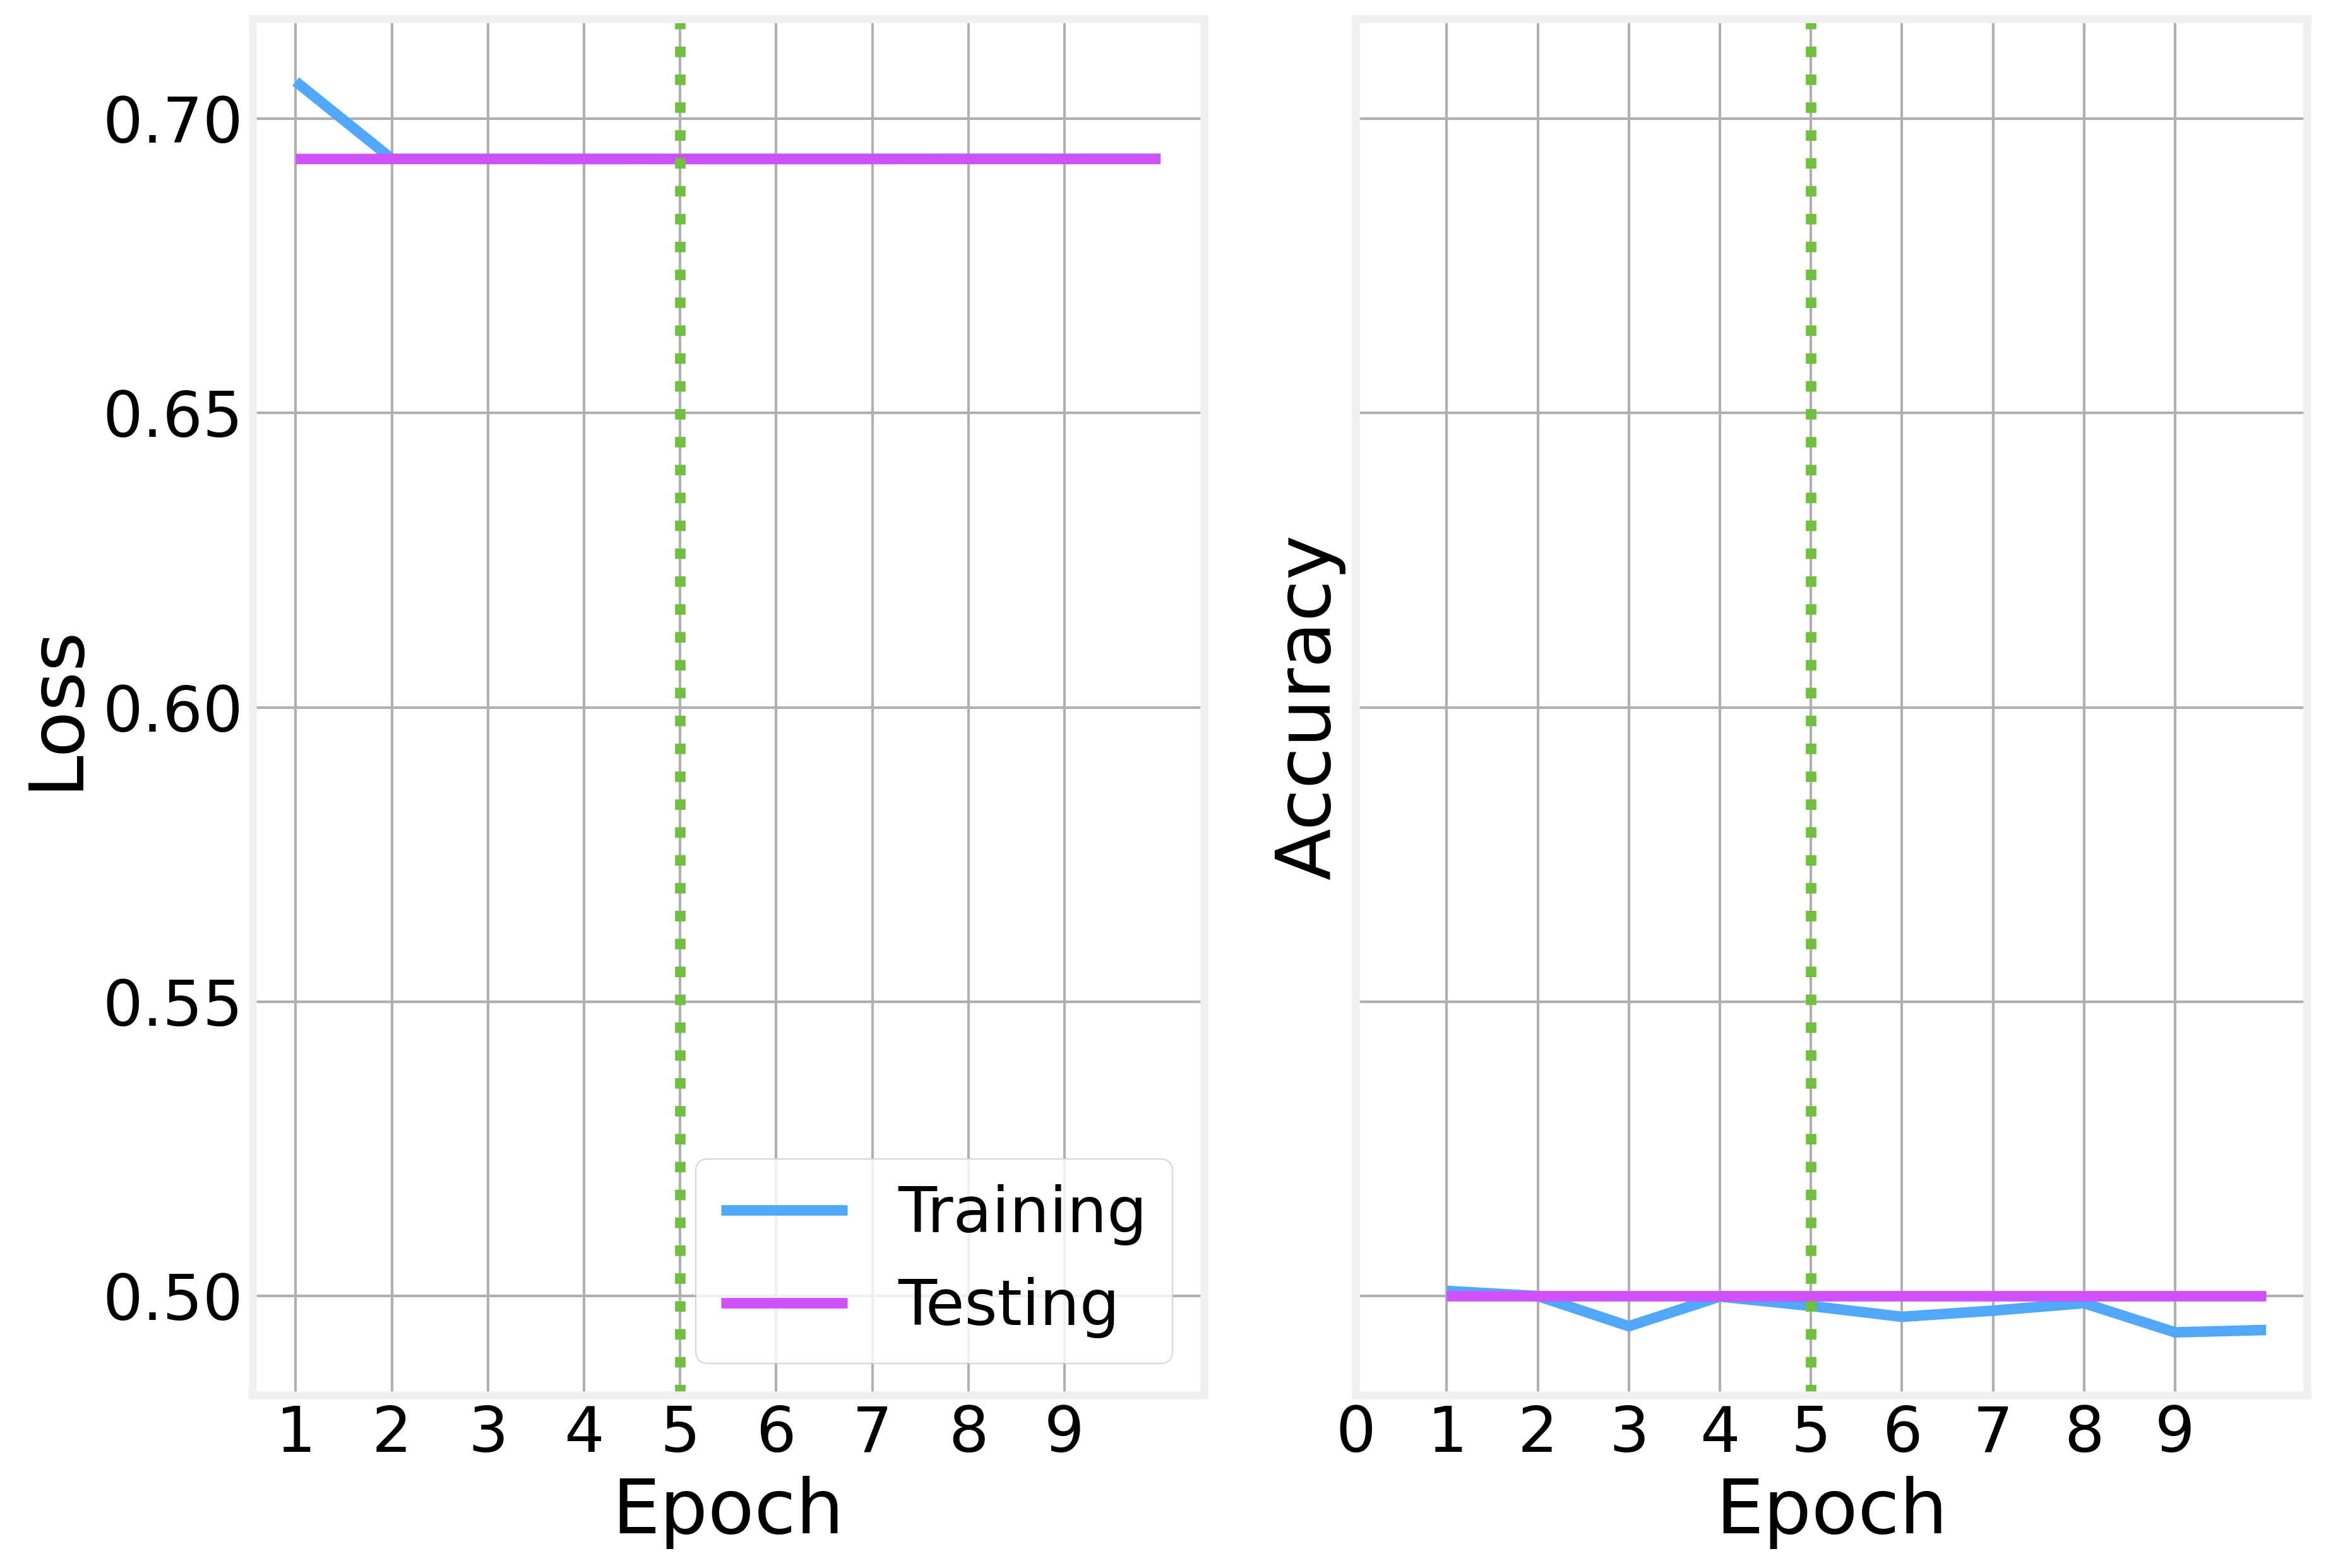

In [17]:
plot_history(history)

# Convolutional Model

In [18]:
model = Sequential()
model.add(Embedding(top_words, 50, input_length=max_words))

model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 50)           500000    
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 32)           4832      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 250, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                256032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 760,897
Trainable params: 760,897
Non-trainable params: 0
________________________________________________

In [19]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False # Don't update the embeddings

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 50)           500000    
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 32)           4832      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 250, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                256032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 760,897
Trainable params: 260,897
Non-trainable params: 500,000
__________________________________________

In [21]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [22]:
history = model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), # The testing data for validation
          epochs=10, # How many epochs to train for
          batch_size=128, # The batch size. Gradients are updated after each batch 
          verbose=1) # The level of detail in the output

Epoch 1/10
196/196 [==============================] - 9s 41ms/step - loss: 0.7309 - accuracy: 0.5056 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 2/10
196/196 [==============================] - 8s 41ms/step - loss: 0.6925 - accuracy: 0.5077 - val_loss: 0.6922 - val_accuracy: 0.5161
Epoch 3/10
196/196 [==============================] - 8s 43ms/step - loss: 0.6906 - accuracy: 0.5230 - val_loss: 0.6907 - val_accuracy: 0.5246
Epoch 4/10
196/196 [==============================] - 8s 41ms/step - loss: 0.6828 - accuracy: 0.5545 - val_loss: 0.6866 - val_accuracy: 0.5493
Epoch 5/10
196/196 [==============================] - 8s 42ms/step - loss: 0.6656 - accuracy: 0.5943 - val_loss: 0.6709 - val_accuracy: 0.6049
Epoch 6/10
196/196 [==============================] - 8s 42ms/step - loss: 0.6216 - accuracy: 0.6700 - val_loss: 0.6725 - val_accuracy: 0.6194
Epoch 7/10
196/196 [==============================] - 8s 43ms/step - loss: 0.5709 - accuracy: 0.7212 - val_loss: 0.6960 - val_accuracy: 0.6186

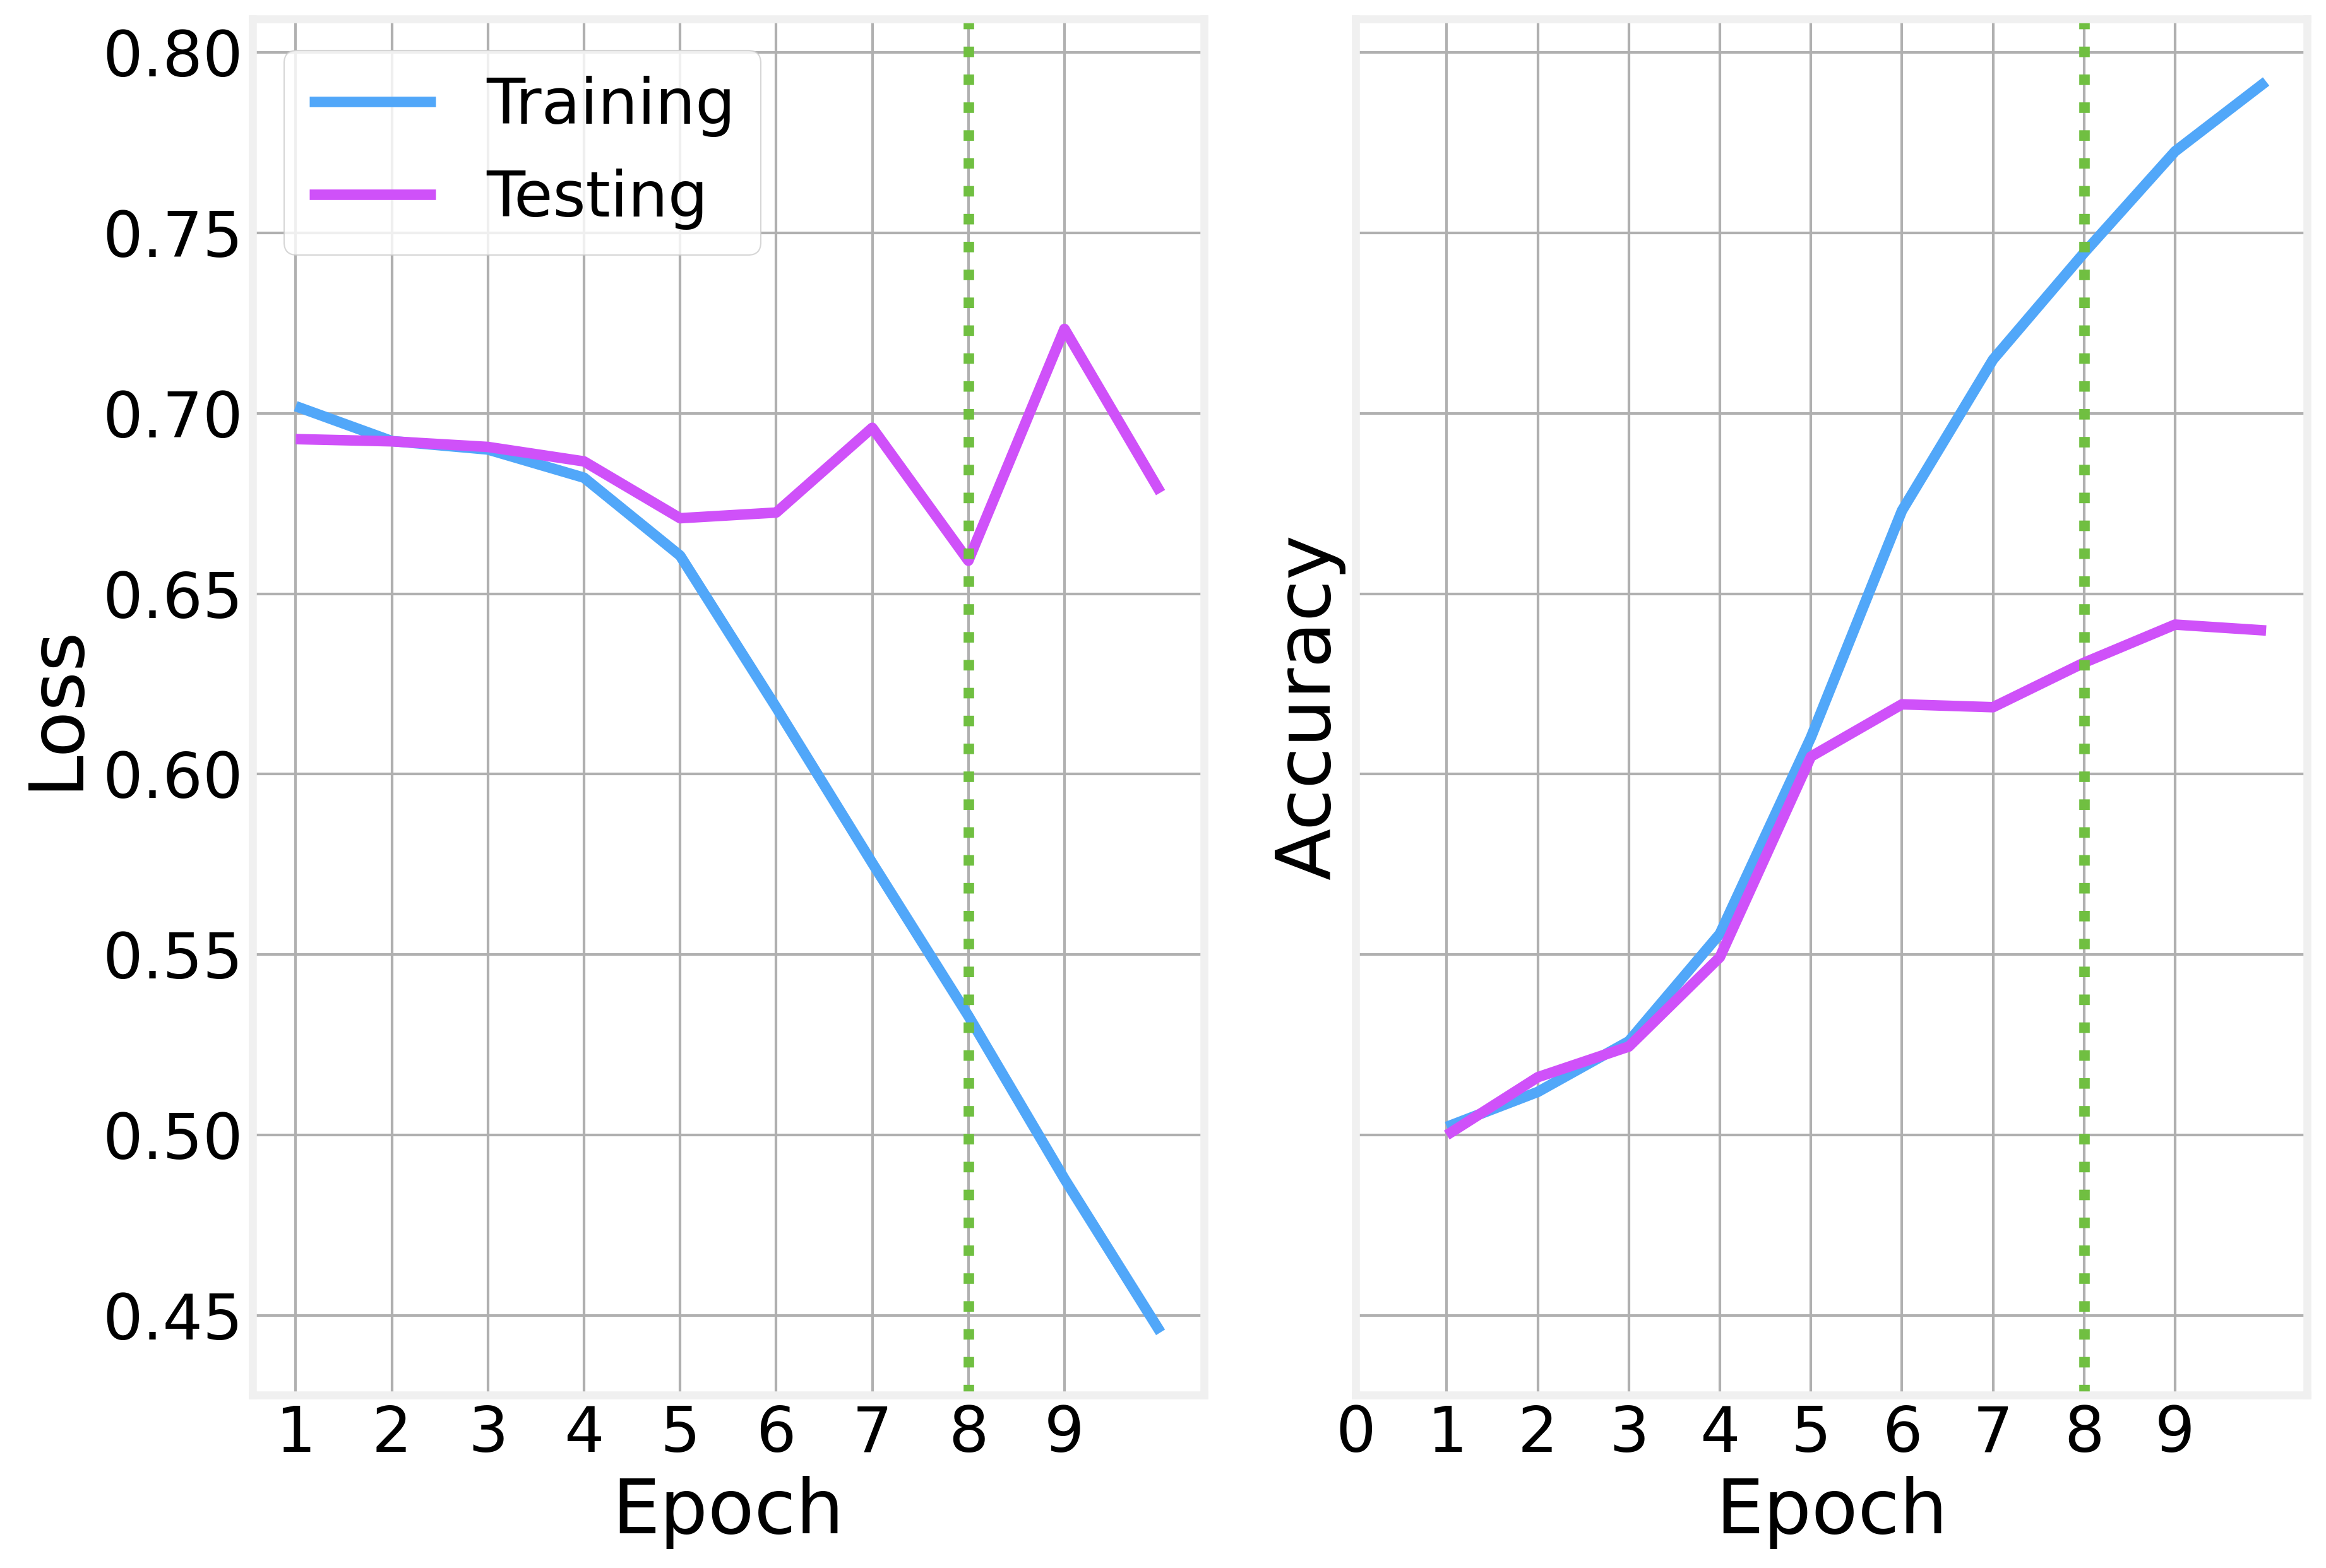

In [23]:
plot_history(history)

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>